## **Database Preparation by splitting into Training and Validation sets**



In [ ]:
import os
import shutil
import json
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We create the subfolders 0 , 1, 2 of the "*training*" folder.

In [ ]:
train0_dir = os.path.join('/content/drive/My Drive/MaskDataset/training','0')
if not os.path.exists(train0_dir):
    os.makedirs(train0_dir)

train1_dir = os.path.join('/content/drive/My Drive/MaskDataset/training','1')
if not os.path.exists(train1_dir):
    os.makedirs(train1_dir)

train2_dir = os.path.join('/content/drive/My Drive/MaskDataset/training','2')
if not os.path.exists(train2_dir):
    os.makedirs(train2_dir)

With the json file we create three lists containing the names of the images associated to each class (e.g. "*14985.jpg*") and then we move the images from the folder "*training*" to the respective subfolders.

In [ ]:
file = open('/content/drive/My Drive/MaskDataset/train_gt.json')
data = json.load(file)

img_0 = [k for k,v in data.items() if v == 0]
img_1 = [k for k,v in data.items() if v == 1]
img_2 = [k for k,v in data.items() if v == 2]

In [ ]:
for el0 in img_0:
  try:
    shutil.move(os.path.join('/content/drive/My Drive/MaskDataset/training',el0), train0_dir)
  except:
    continue

for el1 in img_1:
  try:
    shutil.move(os.path.join('/content/drive/My Drive/MaskDataset/training',el1), train1_dir)
  except:
    continue

for el2 in img_2:
  try:
    shutil.move(os.path.join('/content/drive/My Drive/MaskDataset/training',el2), train2_dir)
  except:
    continue


We create the "*validation*" folder and its subfolders 0 , 1, 2.


In [ ]:

valid_dir = os.path.join('/content/drive/My Drive/MaskDataset','validation')
if not os.path.exists(valid_dir):
    os.makedirs(valid_dir)

valid0_dir = os.path.join(valid_dir,'0')
if not os.path.exists(valid0_dir):
    os.makedirs(valid0_dir)

valid1_dir = os.path.join(valid_dir,'1')
if not os.path.exists(valid1_dir):
    os.makedirs(valid1_dir)

valid2_dir = os.path.join(valid_dir,'2')
if not os.path.exists(valid2_dir):
    os.makedirs(valid2_dir)


We randomly take the 16% of each class from the "*training*" folder and put it in the "*validation*" folder

In [ ]:
perc= 0.16

sample0=random.sample(img_0, k=int(perc*len(img_0)))

sample1 =random.sample(img_1, k=int(perc*len(img_1)))

sample2=random.sample(img_2, k=int(perc*len(img_2)))

In [ ]:
for s0 in sample0:
  try:
    shutil.move(os.path.join('/content/drive/My Drive/MaskDataset/training/0',s0), valid0_dir)
  except:
    print('i')

for s1 in sample1:
  try:
    shutil.move(os.path.join('/content/drive/My Drive/MaskDataset/training/1',s1), valid1_dir)
  except:
    print('i')

for s2 in sample2:
  try:
    shutil.move(os.path.join('/content/drive/My Drive/MaskDataset/training/2',s2), valid2_dir)
  except:
    print('i')


## **Loading Data and Saving as .npy**
We load all the data in the Colab environment from their respective folders in Google Drive. Then we save them again in Google Drive as .npy files.


In [ ]:
import os
import numpy as np
np.random.seed(1234)

import pandas as pd
import cv2

In [ ]:
def load_data(label_names,directory):
  
    images = []
    labels = []

    for folder in os.listdir(directory):
        curr_label = label_names.index(folder)

        for file in os.listdir(directory + "/" + folder):
            img_path = directory + "/" + folder + "/" + file
            curr_img = cv2.imread(img_path)
            images.append(curr_img)
            labels.append(curr_label)

    images = np.array(images) 
    labels = np.array(labels) 

    return (images, labels)

In [ ]:
dataset_dir = os.path.join('/content/drive/My Drive', 'MaskDataset')
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')

classes = ['0',       # AllMask
           '1',         # NoMask
           '2']      # SomeMask

(X, y) = load_data(classes, training_dir)
(X_val, y_val) = load_data(classes, validation_dir)


In [ ]:
np.save('/content/drive/My Drive/training.npy', X)
np.save('/content/drive/My Drive/validation.npy', X_val)
np.save('/content/drive/My Drive/train_target.npy', y)
np.save('/content/drive/My Drive/validation_target.npy', y_val)

## **Creating 3x3 grid images and Saving as .npy**
We load all the data in the Colab environment from .npy files Google Drive. We use only 9 faces for each image because we have noticed from the database that, in general, no more than 5-6 people per picture wear a mask.

Then we apply to them the function squarer that returns an image as in the example:



The *detect* method of our detector returns a tensor with shape [N, 5], where N is number of faces and the five elements are [xmin, ymin, xmax, ymax, detection_confidence].

Our idea is that if the detector finds a bounding box too small, this is probably an error or anyway a really small face, surely not wearing a mask. For this reason we are removing from the tensor those elements. In the case our tensor remains void we have thought to fill the whole image with a presaved "*NoMask*" face repeated 9 times (*10340.jpg*).

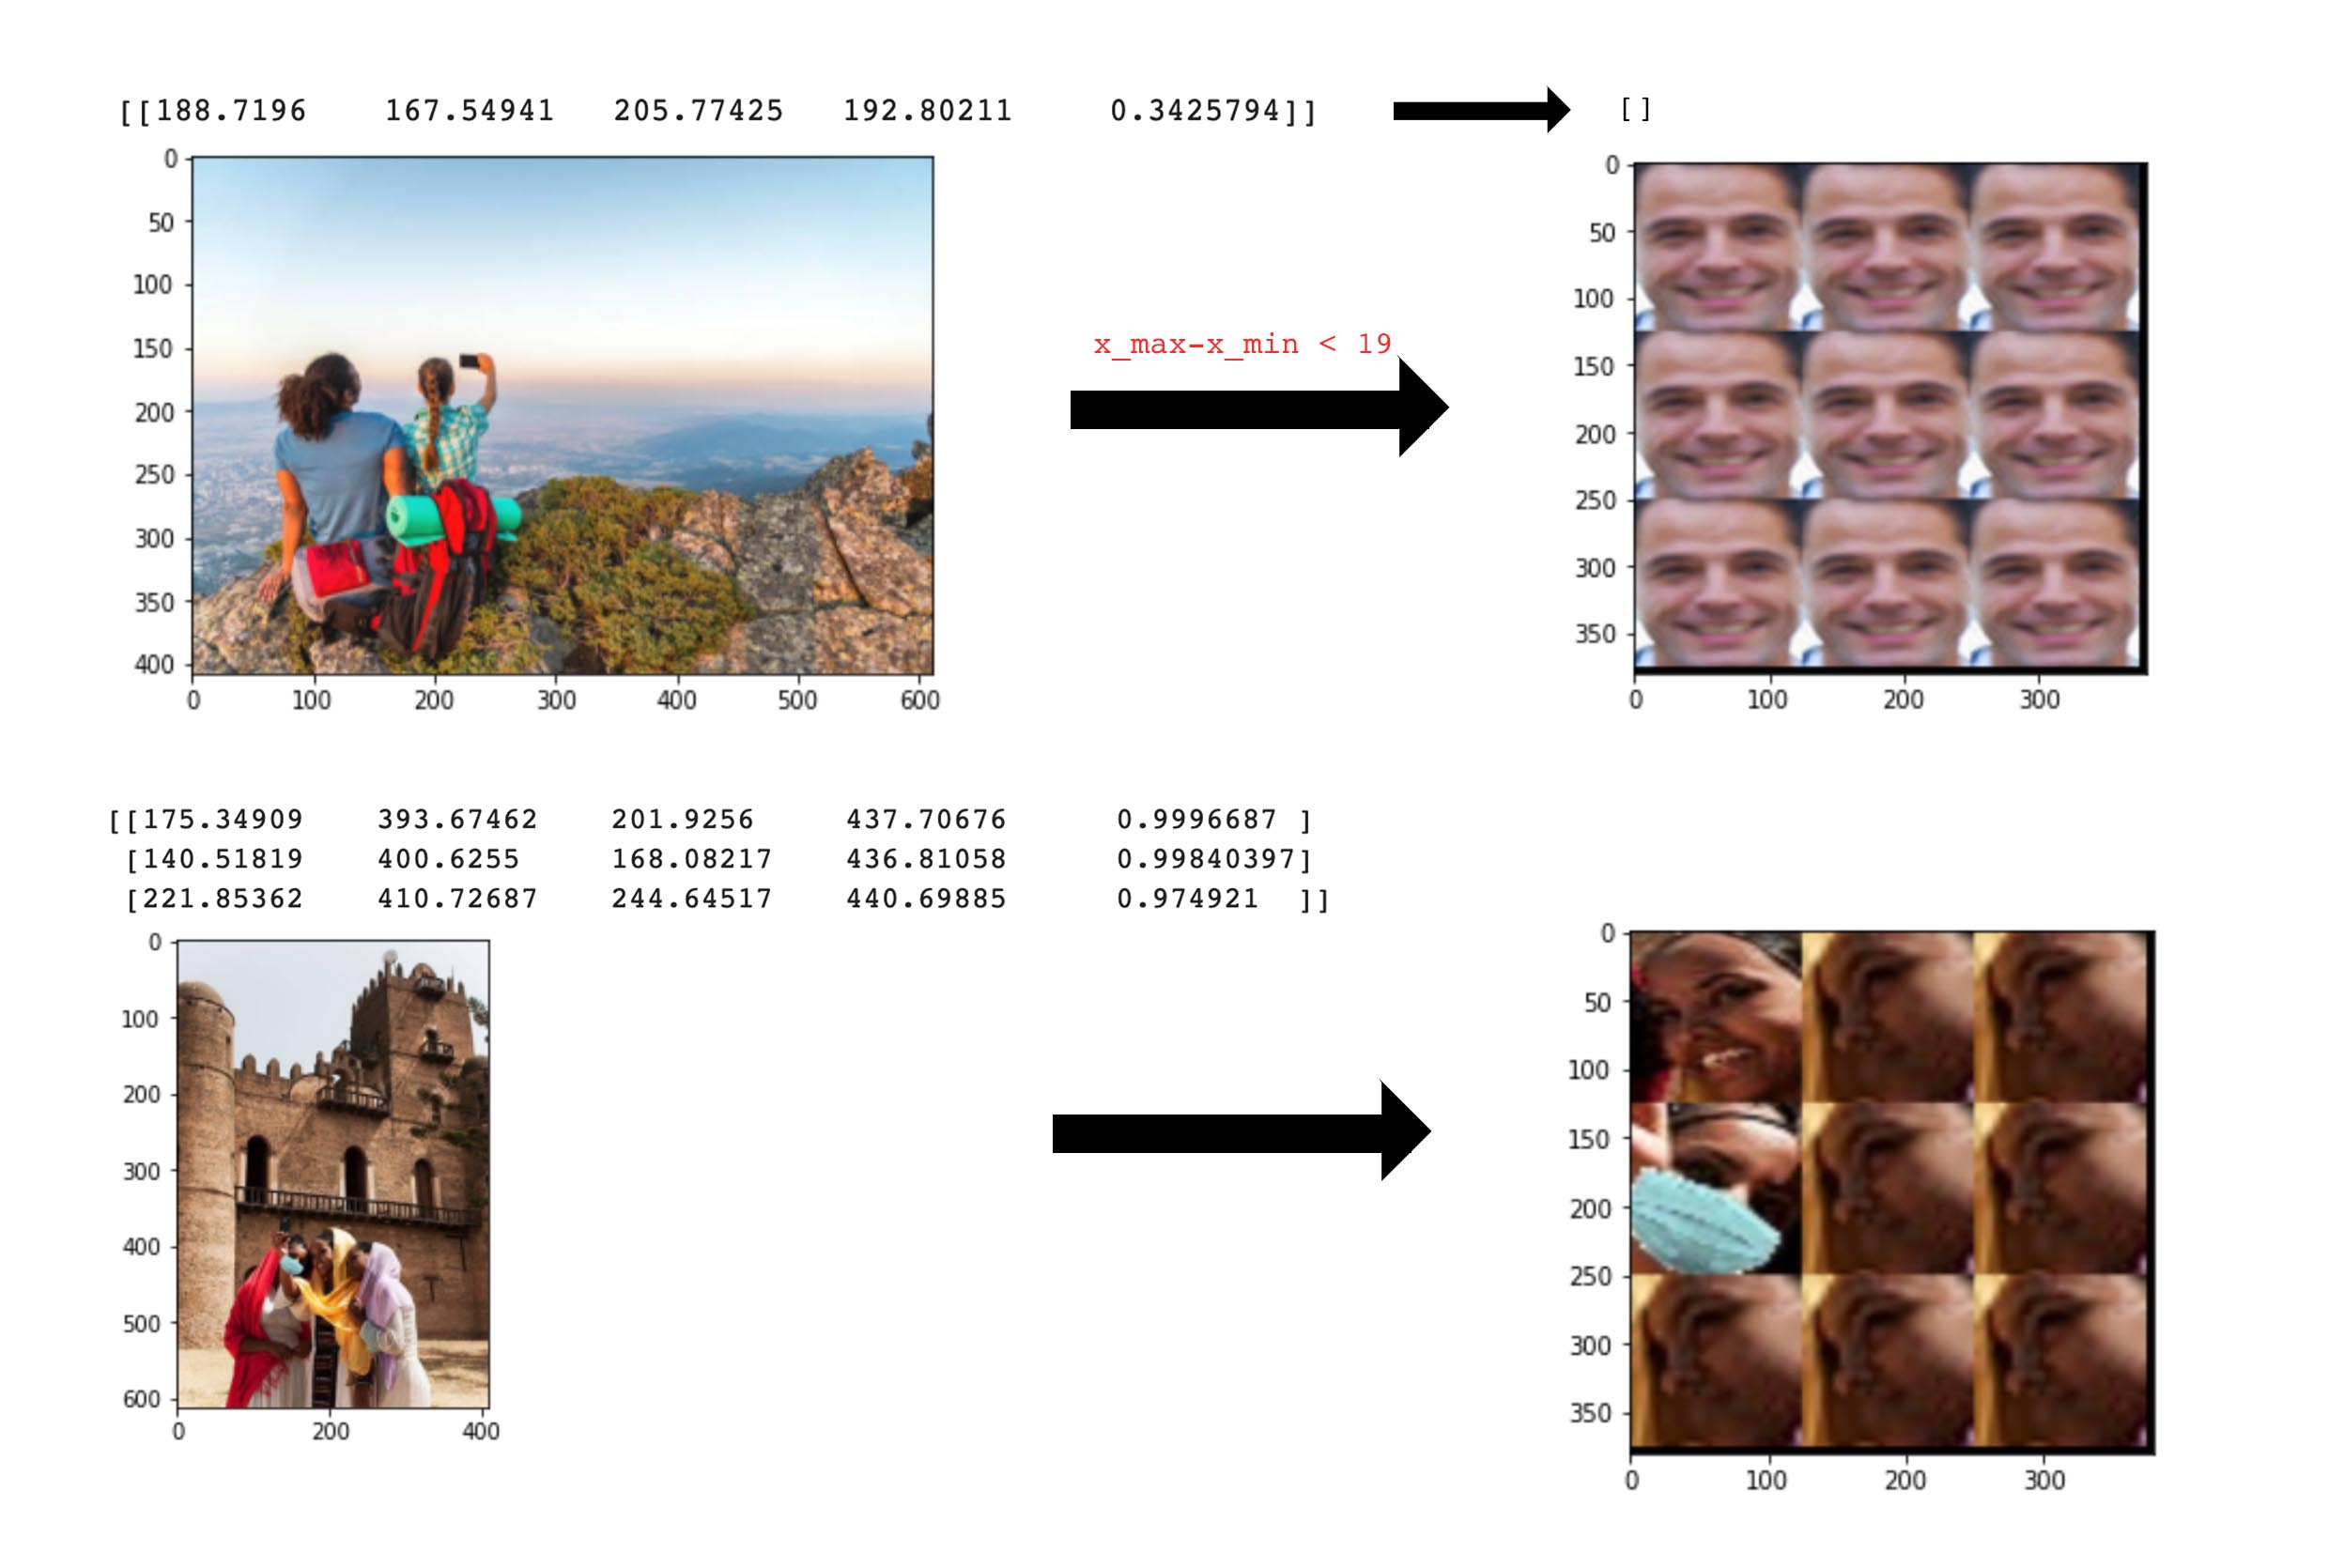

In [ ]:
detector = face_detection.build_detector("DSFDDetector", confidence_threshold=.2, nms_iou_threshold=.3) 

im_empty = cv2.imread(training_dir + '/0/10340.jpg')
im_empty = cv2.cvtColor(im_empty, cv2.COLOR_BGR2RGB)
face_empty = detector.detect(im_empty)
print(face_empty)
plt.imshow(face_empty)

In [ ]:
def squarer(file, result_list):
	file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB)

	#Creating a dark square with NUMPY 

	shape = 380 
	grid = np.zeros((shape,shape,3),np.uint8)
	
  threshold = 19
	imgsz = int(shape/3)-1  # -1 in order to keep the image inside the grid
	lung=len(result_list)

  # Searching for elements with dimensions under threshold and removing them
	
  it=0
	while it <= (len(result_list)-1):

		if it < lung:    
			if int(result_list[it][2]-result_list[it][0]) < threshold or int(result_list[it][3]-result_list[it][1]) < threshold:
				result_list = np.delete(result_list,it,0)		
				lung = len(result_list)		
				it = it-1
		else: break 
		it = it+1

  # If the vector is empty we fill the image with the face_empty[0] face
   
	if len(result_list)==0:
		face0 = im_empty[int(face_empty[0][1]):int(face_empty[0][3]),int(face_empty[0][0]):int(face_empty[0][2])]
		face0 = cv2.resize(face0,(a,a))
		for i in range(3):
			for j in range(3):
				grid[j*imgsz:(j+1)*imgsz, i*imgsz:(i+1)*imgsz] = face0

  # Otherwise we crop every face from the original file and we copy it to the grid until all the faces are finished.
  # After that, if there is still space in the grid, we proceed by filling the remaining boxes with the last face found

	else:
		for i in range(3):
			for j in range(3):
				if (3*i+j)<len(result_list):
					newface = file[int(abs(result_list[i*3+j][1]-2)):int(abs(result_list[i*3+j][3]+2)), int(abs(result_list[i*3+j][0]-2)):int(abs(result_list[i*3+j][2]+2))]
					newface = cv2.resize(newface, (imgsz, imgsz))
					grid[j*imgsz:(j+1)*imgsz, i*imgsz:(i+1)*imgsz] = newface

				else:
					grid[j*imgsz:(j+1)*imgsz, i*imgsz:(i+1)*imgsz] = newface				
	return grid

We iterate the process for the whole database and then we save the results in a .npy format

In [ ]:
square=[]
squareval=[]

for img in X: 
	faces = detector.detect(img)
	square.append(squarer(img, faces))

for img in X_val: 
	faces = detector.detect(img)
	squareval.append(squarer(img, faces))

In [ ]:
np.save('/content/drive/My Drive/trainingsquare380', square)
np.save('/content/drive/My Drive/trainingsquare380val', squareval)